In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import, print_function, division

In [3]:
from operator import itemgetter
import numpy as np
import tensorflow as tf
from GomokuBoard import GomokuBoard
from Heuristics import Heuristics
from HeuristicPolicy import HeuristicGomokuPolicy
from GomokuTools import GomokuTools as gt

In [4]:
tf.__version__

'1.13.1'

In [5]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

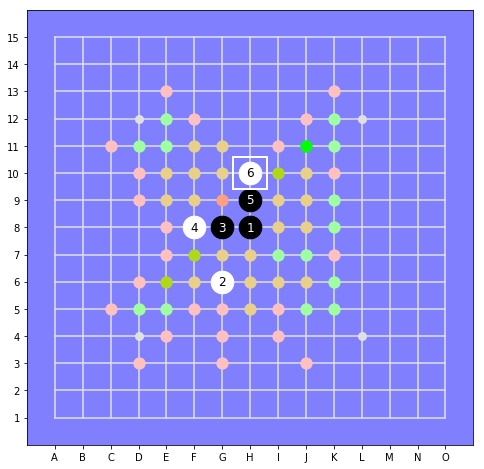

In [7]:
heuristics = Heuristics(kappa=3.0)
board = GomokuBoard(heuristics, N=15, disp_width=8)
policy = HeuristicGomokuPolicy(bias=.5, style=2, topn=5)
board.set(H,8).set('G',6).set(G,8).set(F,8).set(H,9).set(H,10)
board.display('current');

In [8]:
def variants_for(board):
    """
    Create a tensor 8x2xNxN to represent the 8 equivalent boards 
    that can be created from the stones by reflection and rotation.
    """
    stones = board.stones.copy()
    N = board.N
    array=np.zeros([8,2,N,N], dtype=float)
    color = np.arange(len(stones)) % 2
    for l, pos in list(zip(color, stones)):
        r, c = gt.b2m(pos, 15)
        array[0][l][r][c] = 1.0
        array[6][l][c][r] = 1.0

        array[1][l][c][N-r] = 1.0
        array[4][l][N-r][c] = 1.0

        array[3][l][N-c][r] = 1.0
        array[7][l][r][N-c] = 1.0

        array[2][l][N-r][N-c] = 1.0
        array[5][l][N-c][N-r] = 1.0

    return array

In [9]:
mt = variants_for(board)

Let's have a look at one of the boards

In [10]:
orientation = 3
mt[orientation][0] + 2*mt[orientation][1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

### Play and record a game

In [14]:
def roll_out(heuristics):
    board = GomokuBoard(heuristics, N=15, disp_width=8)
    policy = HeuristicGomokuPolicy(bias=.5, style=2, topn=5)
    board.set(H,8).set('G',6).set(G,8).set(F,8).set(H,9).set(H,10)
    n = 0
    board.compute_all_scores()
    move = policy.suggest(board)
    while move.status == 0 and n < 100:
        board.set(move.x,move.y)
        board.compute_all_scores()
        move = policy.suggest(board)
        n+=1
    return board

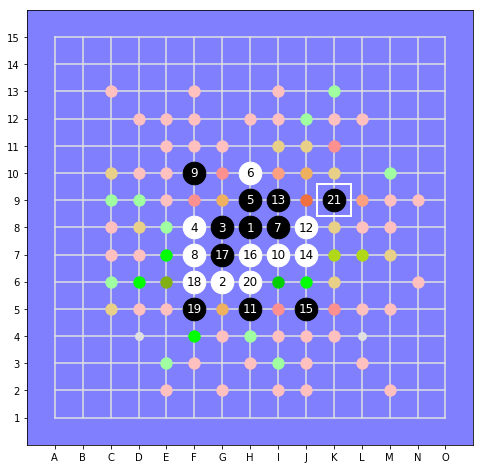

In [15]:
board = roll_out(heuristics)
board.display('current')

---
### Heuristic Q Function

In [18]:
board = GomokuBoard(heuristics, N=15, disp_width=8)
policy = HeuristicGomokuPolicy(bias=.5, style=2, topn=5)
board.set(H,8).set('G',6).set(G,8).set(F,8).set(H,9).set(H,10).set(F,7);

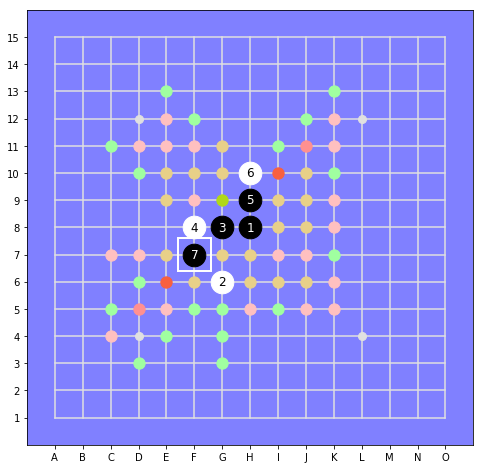

In [19]:
board.display('current')

### A meaningful definition for the heuristic Q function

Note that this function is just the initial estimate for the Q-function that we'll set out to find with Deep QLearning

- If there is at least one serious threat >= 6.9, then every QValue other than those threats must be -9999.

- If there is at least one win >= 6.9 then all winners get 9999, every QValue other than those is simply $0$

- If there is no critical value, the QValue estimate of any one of the the N best moves is the value of the board after taking that move and observing the best response. For the sake of computational efficiency, all other fields' QValues are approximated by the least significant move followed by the best response

In [20]:
from QFunction import enumerated_top
enumerated_top(board, 4)

[[((6, 6), 4.999999999999999),
  ((8, 4), 3.9999999999999996),
  ((4, 8), 3.9999999999999996),
  ((9, 3), 2.8693967741585835)],
 [((9, 4), 7.0),
  ((5, 8), 7.0),
  ((10, 3), 5.499999999999999),
  ((4, 9), 5.499999999999999)]]

In [21]:
from QFunction import heuristic_QF, value_after

(array([[-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        ],
        [-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        ],
        [-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        ],
        [-200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
         -200.        , -200.        , -200.        , -200.        ,
       

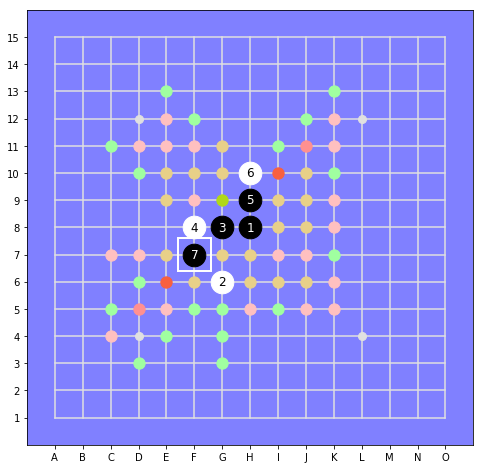

In [22]:
board.display('current')
q = heuristic_QF(board, policy)
q

#### Plausibly, the heuristic Q function reflects the policy's choice

In [31]:
## The policy
move = policy.suggest(board, topn=1, bias=0.02)
print("Suggested Move: " + move.__repr__()) 
print("Value after the move: " + str(value_after(board, (move.x, move.y), policy)))

## The Q function
r,c=gt.b2m((move.x, move.y), board.N)
print("Q Value: " + str(q[0][r][c]))

Suggested Move: Defending Win-in-2: (E, 6)
Value after the move: -16.23676610932712
Q Value: -16.23676610932712
